In [1]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
import statsmodels.api as sm
from statsmodels.formula.api import ols
import celloracle as co
import os
import sys
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import math
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
import random
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

which: no R in (/bgfs/rgottschalk/Sonia/envs/celloracle_new/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin/:/ihome/rgottschalk/sok65/.local/bin:/ihome/rgottschalk/sok65/bin)
/bgfs/rgottschalk/Sonia/envs/celloracle_new/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
adatapath = '20251111_RAM_MoM_scRNAseq_GSE280003.h5ad'
adata = sc.read_h5ad(adatapath)
adata

AnnData object with n_obs × n_vars = 23924 × 2381
    obs: 'time', 'macType', 'unique', 'n_counts', 'louvain'
    var: 'mean', 'std'
    uns: 'diffmap_evals', 'draw_graph', 'log1p', 'louvain', 'macType_colors', 'neighbors', 'paga', 'pca', 'time_colors', 'unique_colors', 'unique_sizes'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

In [4]:
myTSNEfile = 'topicModeling/20251210_MoMac_tsne_coords.csv'
myTSNE = pd.read_csv(myTSNEfile, index_col=0).reindex(adata.obs_names).to_numpy()
topic_file = 'topicModeling/20251210_topicModeling_fit7_MoMac_L.csv'
topics = pd.read_csv(topic_file, index_col=0).reindex(adata.obs_names)
topics

,k1,k2,k3,k4,k5,k6,k7
index,,,,,,,
AAACCCAAGAGAGCGG-1_GSM8585457,5.154604e-02,9.134993e-12,0.002331,0.239927,5.248545e-01,0.110121,0.071221
AAACCCATCCCAGCGA-1_GSM8585457,5.100491e-02,2.396870e-11,0.025715,0.210694,4.908261e-01,0.091023,0.130737
AAACGAACAAGTATAG-1_GSM8585457,5.663524e-04,5.067079e-12,0.011181,0.004129,5.349696e-01,0.078989,0.370165
AAACGAATCGCTGTCT-1_GSM8585457,1.579151e-03,6.351073e-12,0.000702,0.057526,7.085848e-01,0.090140,0.141467
AAACGCTAGATGCTGG-1_GSM8585457,3.391259e-03,7.476941e-12,0.035373,0.055652,5.832767e-01,0.080102,0.242206
...,...,...,...,...,...,...,...
TCTACATAGCTTCATG-1_GSM8585430,7.344867e-04,2.981704e-12,0.030755,0.280242,4.451626e-11,0.033123,0.655145
TTACTGTGTTACCCTC-1_GSM8585430,2.535227e-11,3.477615e-12,0.170948,0.168653,5.192012e-11,0.122609,0.537791
TTCCTTCAGTGATCGG-1_GSM8585430,1.501678e-04,2.903432e-12,0.086121,0.122337,4.334767e-11,0.128123,0.663269


In [5]:
#add topic modeling info to adata
adata.obsm['topic_tsne'] = myTSNE
adata.obs['k7'] = topics['k7']
adata.obs['k4'] = topics['k4']
adata.obs['k5'] = topics['k5']
adata

AnnData object with n_obs × n_vars = 23924 × 2381
    obs: 'time', 'macType', 'unique', 'n_counts', 'louvain', 'k7', 'k4', 'k5'
    var: 'mean', 'std'
    uns: 'diffmap_evals', 'draw_graph', 'log1p', 'louvain', 'macType_colors', 'neighbors', 'paga', 'pca', 'time_colors', 'unique_colors', 'unique_sizes'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'topic_tsne'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

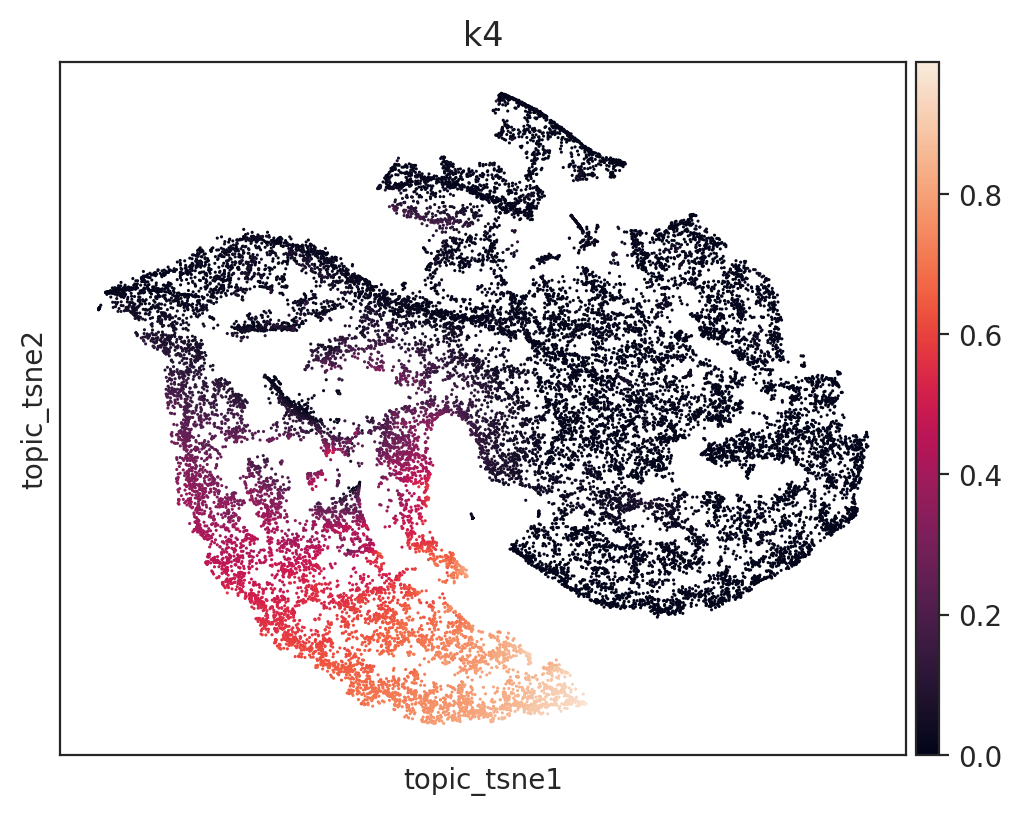

In [6]:
sc.pl.embedding(adata, basis='topic_tsne', color='k4')

In [7]:
chrombpnet_base_GRN = pd.read_parquet('chrombpnet_base_GRN_dataframe.parquet')
chrombpnet_base_GRN

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100487038_100487881,Tmtc3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_100588776_100589421,4930430F08Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr10_100589485_100589556,4930430F08Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_10472072_10472259,Adgb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10472266_10472705,Adgb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36408,chrY_90784646_90784662,Erdr1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36409,chrY_90784672_90784679,Erdr1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36410,chrY_90784685_90785131,Erdr1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36411,chrY_90785157_90785196,Erdr1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
oracle = co.Oracle()

In [9]:
adata.X = adata.layers["raw_count"].copy()
#adata.obs["samplename"] = adata.obs["samplename"].astype("object")
# Instantiate Oracle object
oracle.import_anndata_as_raw_count(adata=adata, cluster_column_name="unique", embedding_name="topic_tsne")

In [10]:
oracle.import_TF_data(TF_info_matrix=chrombpnet_base_GRN)

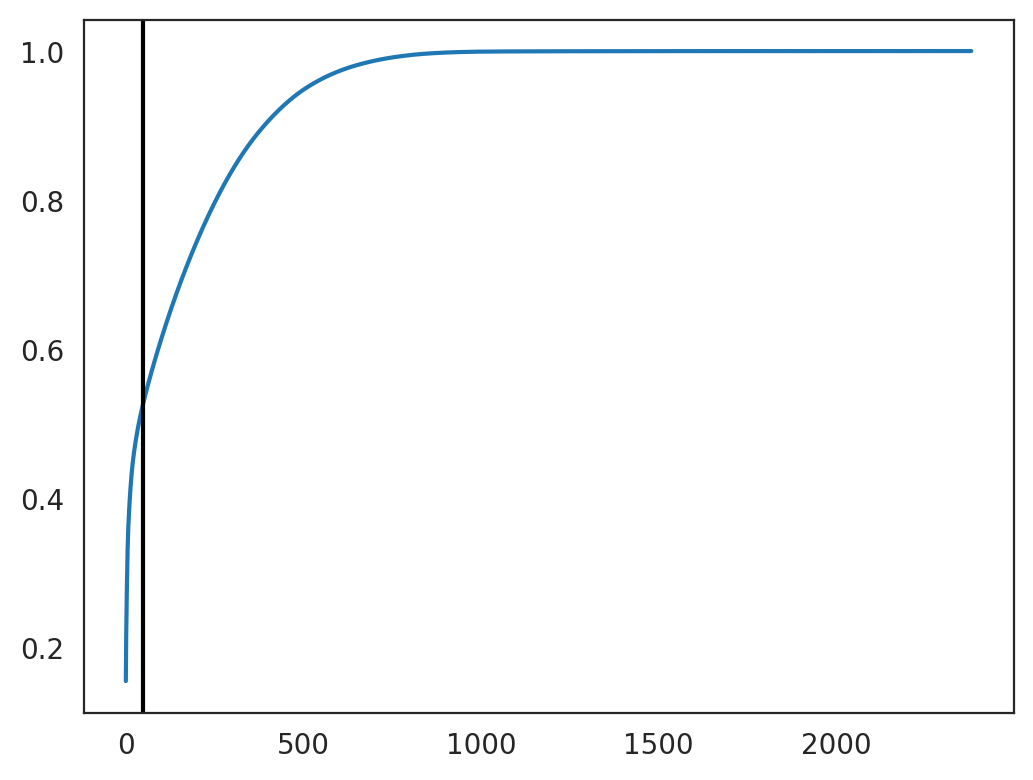

47


In [11]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_))
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [12]:
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :598


In [13]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)

In [14]:
oracle.to_hdf5("20251213_GSE280003_MoMRAM.celloracle.oracle")

In [11]:
chromlinks = oracle.get_links(cluster_name_for_GRN_unit="unique", alpha=5, verbose_level=10)

  0%|          | 0/8 [00:00<?, ?it/s]

Inferring GRN for Homeostasis_D00_MoM...


  0%|          | 0/533 [00:00<?, ?it/s]

Inferring GRN for Homeostasis_D00_RAM...


  0%|          | 0/533 [00:00<?, ?it/s]

Inferring GRN for LPS_D03_MoM...


  0%|          | 0/533 [00:00<?, ?it/s]

Inferring GRN for LPS_D03_RAM...


  0%|          | 0/533 [00:00<?, ?it/s]

Inferring GRN for LPS_D06_MoM...


  0%|          | 0/533 [00:00<?, ?it/s]

Inferring GRN for LPS_D06_RAM...


  0%|          | 0/533 [00:00<?, ?it/s]

Inferring GRN for LPS_D15_MoM...


  0%|          | 0/533 [00:00<?, ?it/s]

Inferring GRN for LPS_D15_RAM...


  0%|          | 0/533 [00:00<?, ?it/s]

In [12]:
chromlinks.filter_links(p=0.001, weight="coef_abs")
chromlinks.links_dict

{'Homeostasis_D00_MoM':         source         target     coef_mean      coef_abs             p  \
 0       Zbtb14  2410017I17Rik  2.260518e-04  2.260518e-04  8.507829e-09   
 1          Maz  2410017I17Rik  1.186960e-04  1.186960e-04  2.375041e-05   
 2        Gtf2i  2410017I17Rik -3.540346e-07  3.540346e-07  9.869572e-01   
 3         Irf3  2410017I17Rik  1.806521e-04  1.806521e-04  5.484958e-07   
 4        Tfdp1  2410017I17Rik  1.276744e-04  1.276744e-04  5.419982e-06   
 ...        ...            ...           ...           ...           ...   
 27434    Stat1        Zscan29 -1.340556e-03  1.340556e-03  2.093906e-02   
 27435     E2f7        Zscan29 -1.124321e-03  1.124321e-03  2.513851e-01   
 27436  Neurod1        Zscan29 -7.011537e-04  7.011537e-04  2.194034e-04   
 27437     Elf2        Zscan29  7.355770e-03  7.355770e-03  1.411225e-06   
 27438  Neurog1        Zscan29 -1.062193e-04  1.062193e-04  3.709892e-01   
 
           -logp  
 0      8.070181  
 1      4.624329  
 2    

In [13]:
RAM_d00_chromGRN = chromlinks.links_dict['Homeostasis_D00_RAM']
RAM_d03_chromGRN = chromlinks.links_dict['LPS_D03_RAM']
RAM_d06_chromGRN = chromlinks.links_dict['LPS_D06_RAM']
RAM_d15_chromGRN = chromlinks.links_dict['LPS_D15_RAM']
MoM_d00_chromGRN = chromlinks.links_dict['Homeostasis_D00_MoM']
MoM_d03_chromGRN = chromlinks.links_dict['LPS_D03_MoM']
MoM_d06_chromGRN = chromlinks.links_dict['LPS_D06_MoM']
MoM_d15_chromGRN = chromlinks.links_dict['LPS_D15_MoM']

Homeostasis_D00_MoM


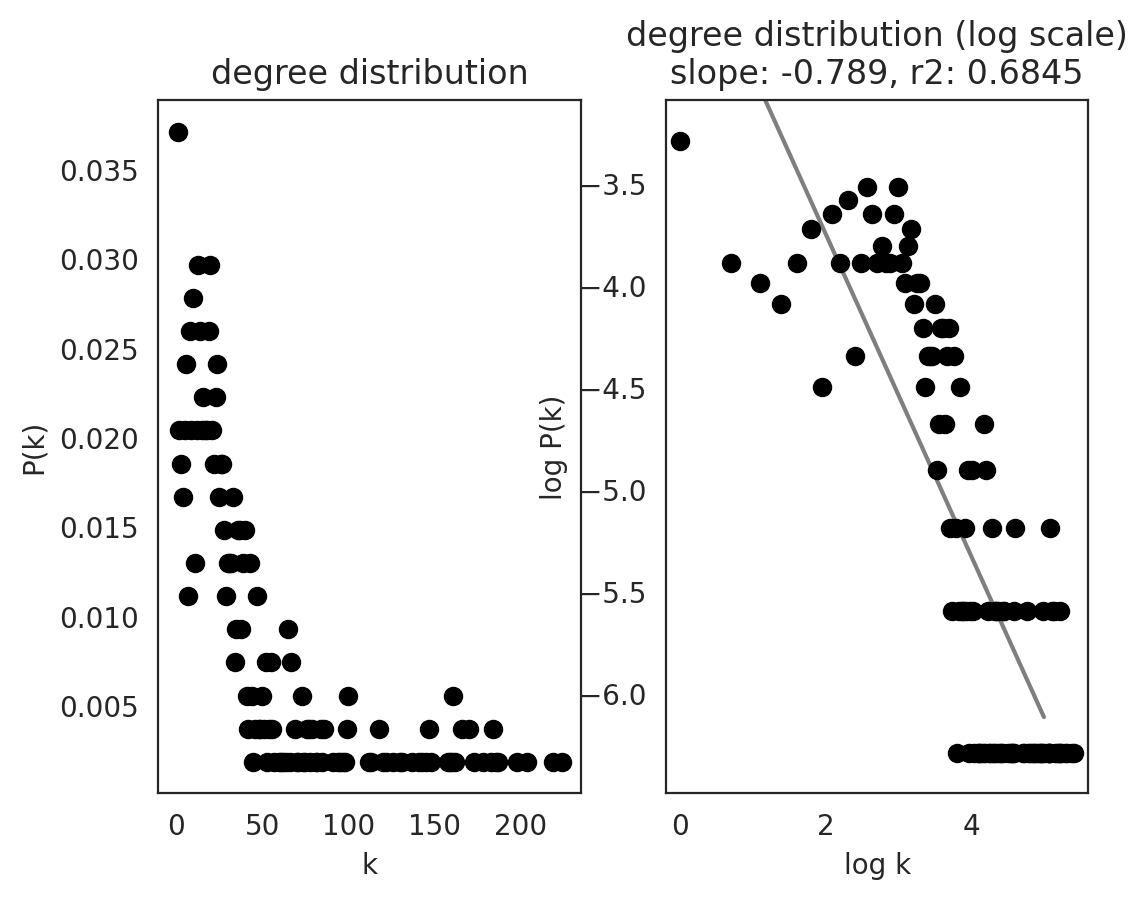

Homeostasis_D00_RAM


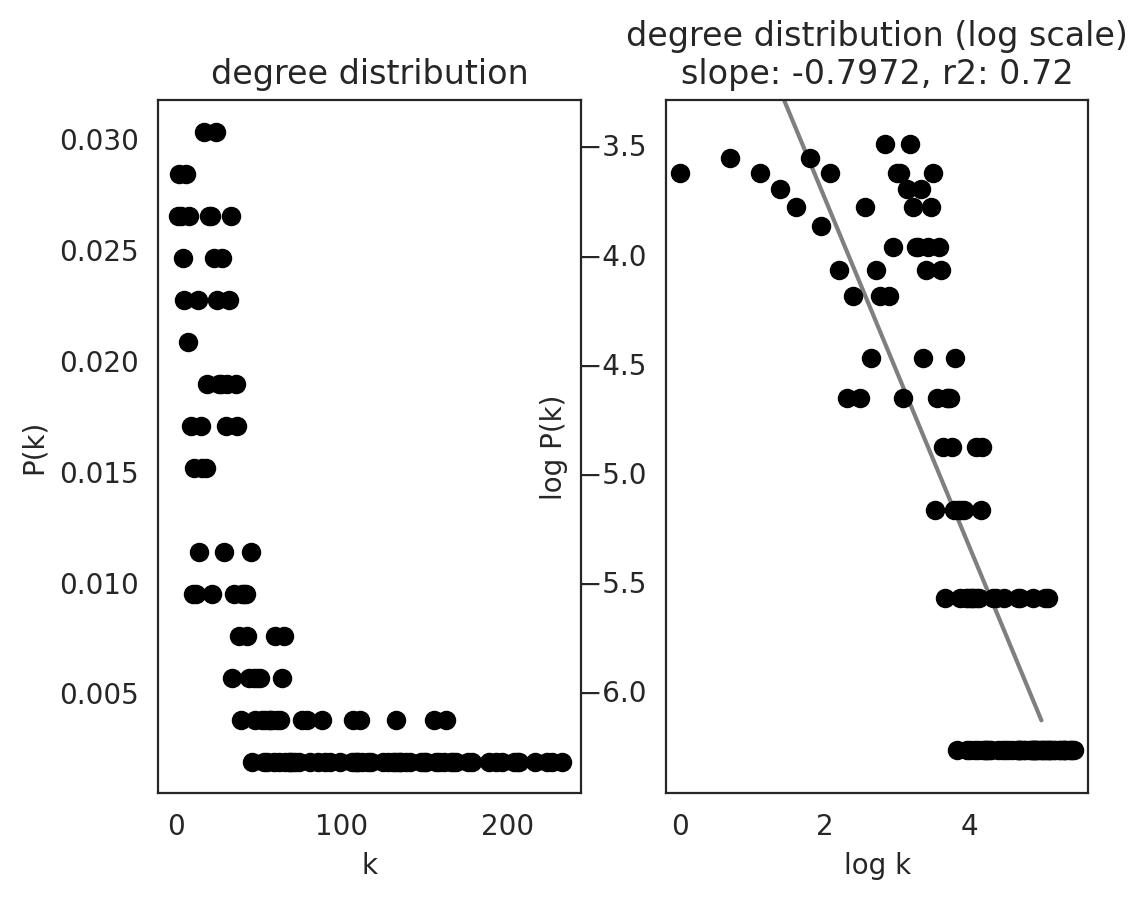

LPS_D03_MoM


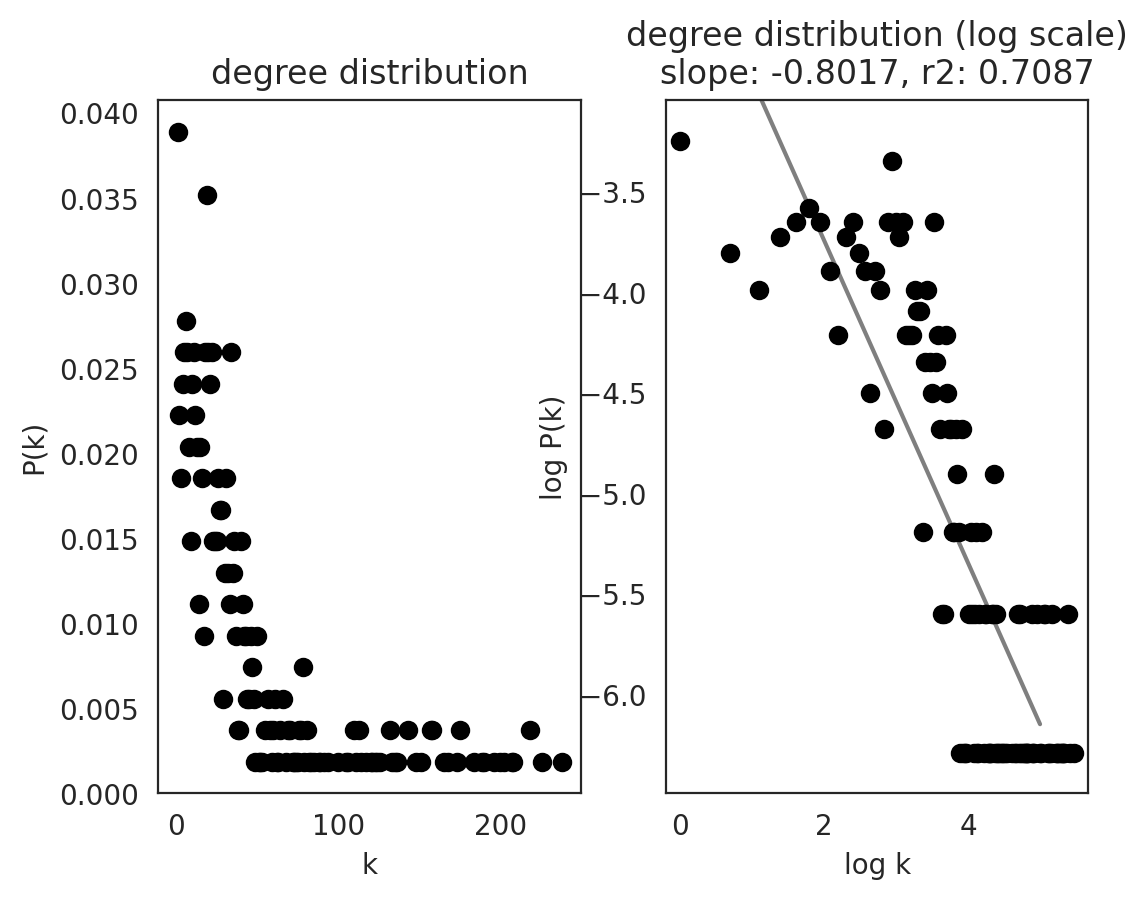

LPS_D03_RAM


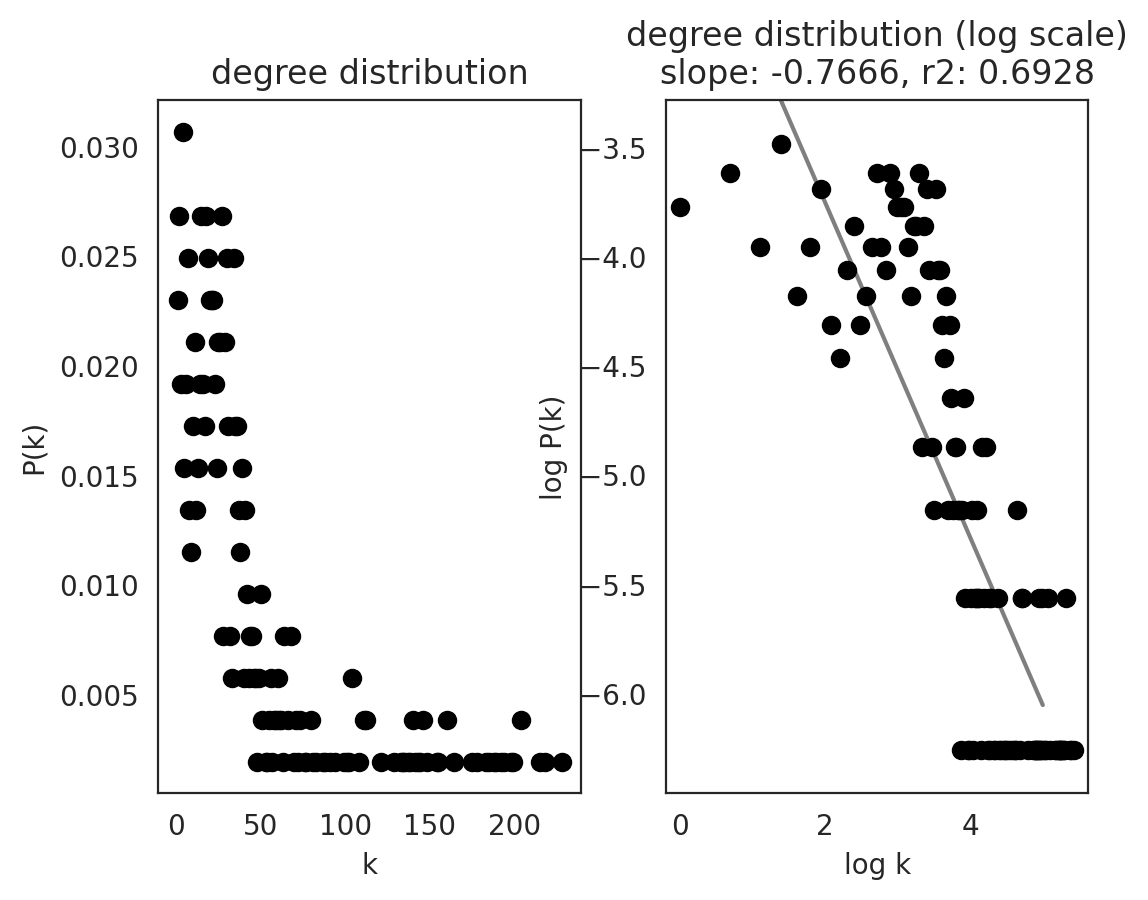

LPS_D06_MoM


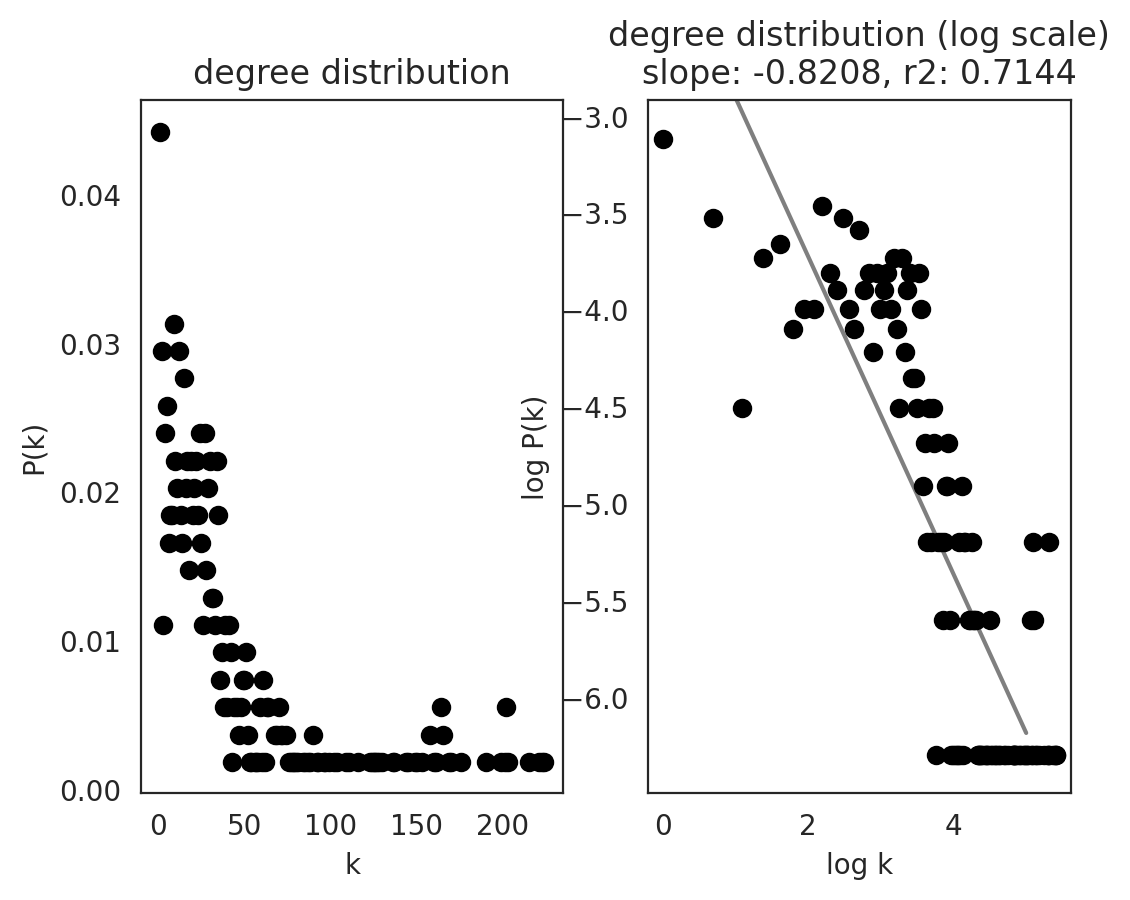

LPS_D06_RAM


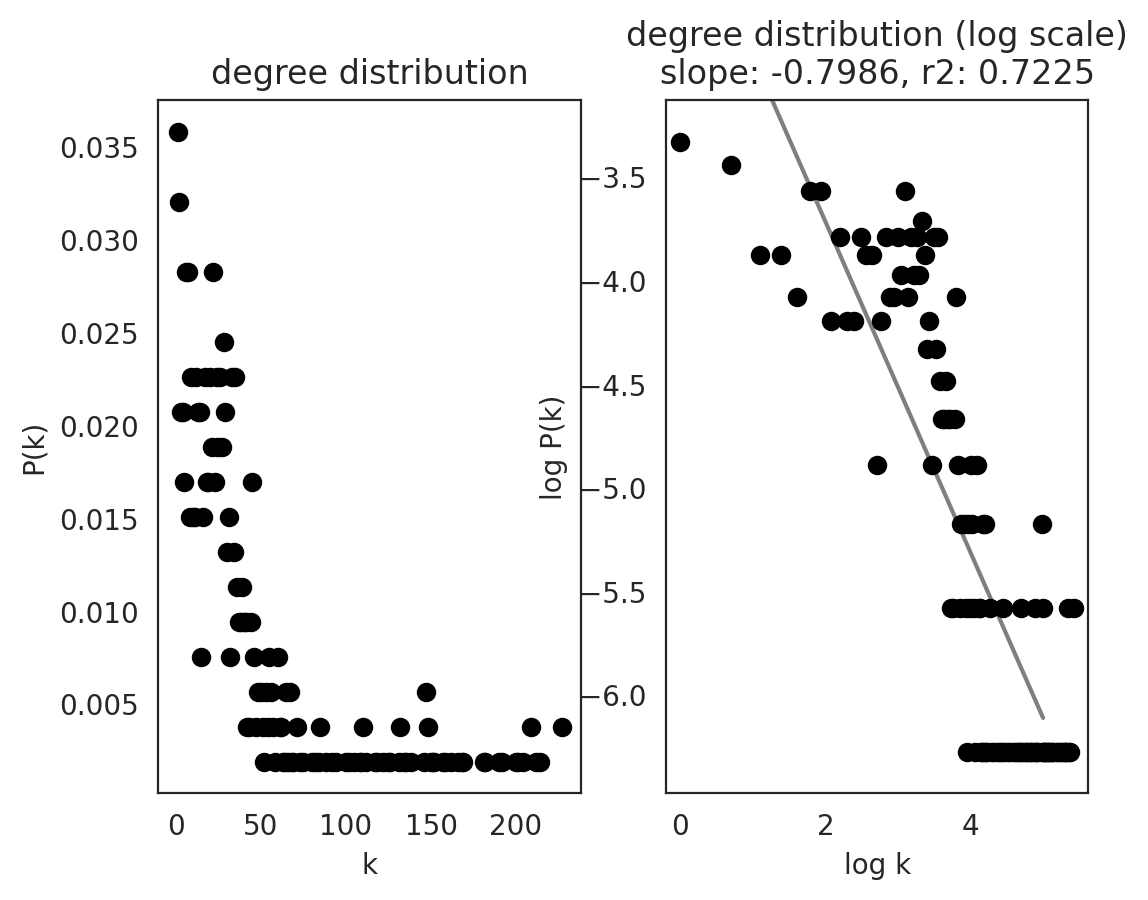

LPS_D15_MoM


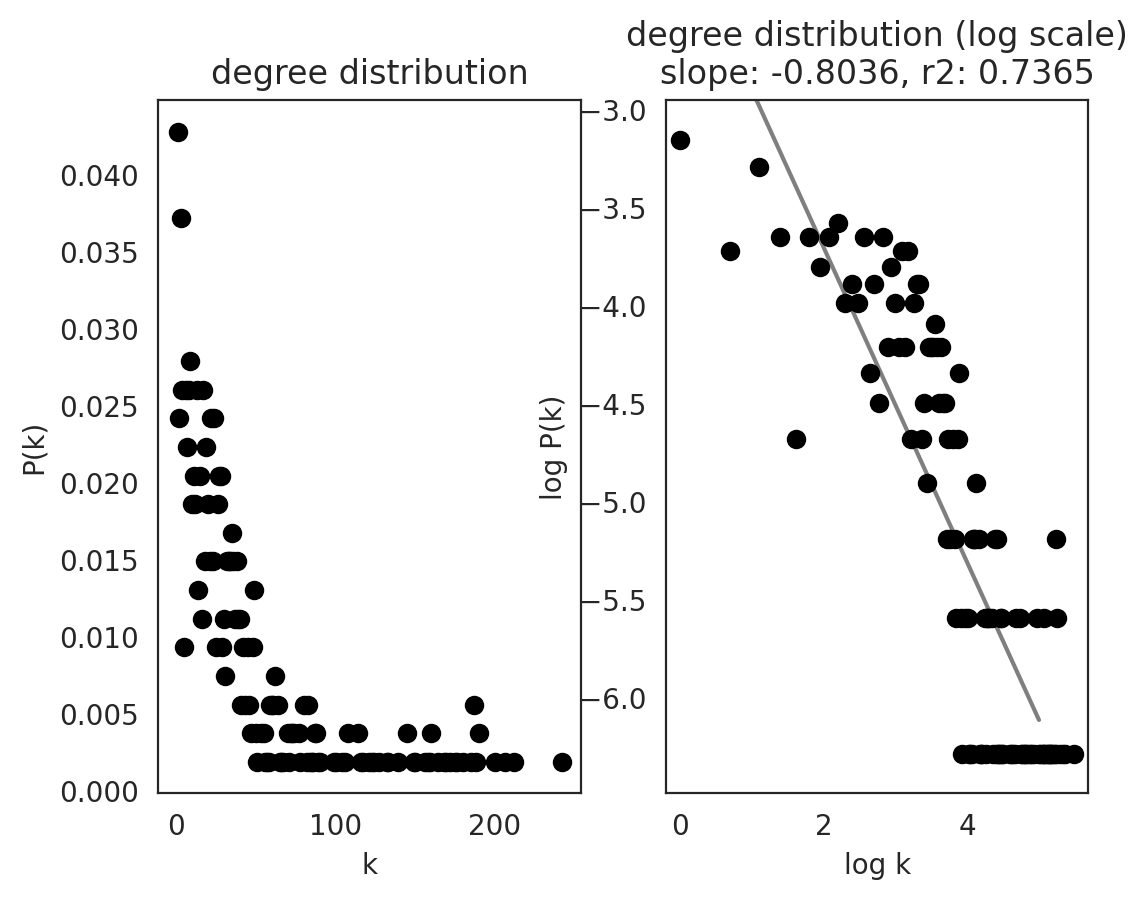

LPS_D15_RAM


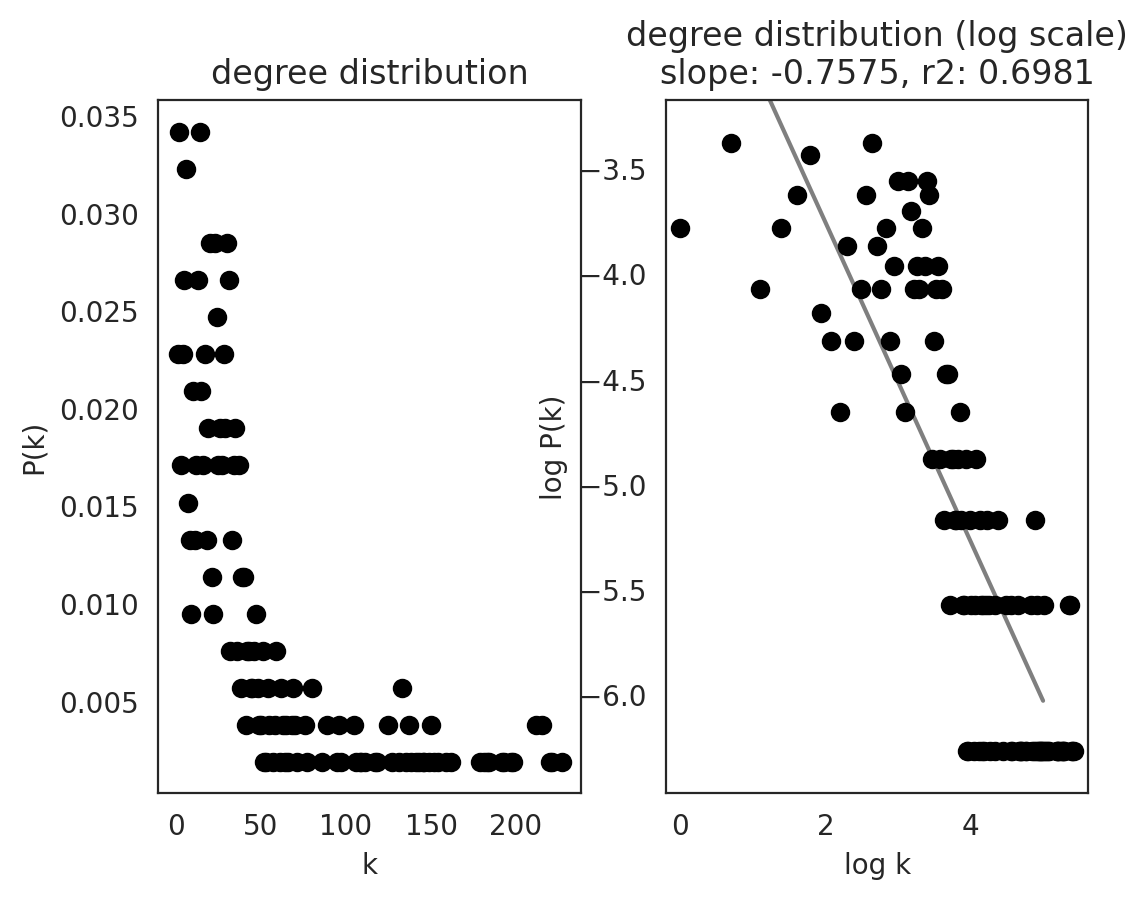

In [14]:
chromlinks.plot_degree_distributions(plot_model=True)

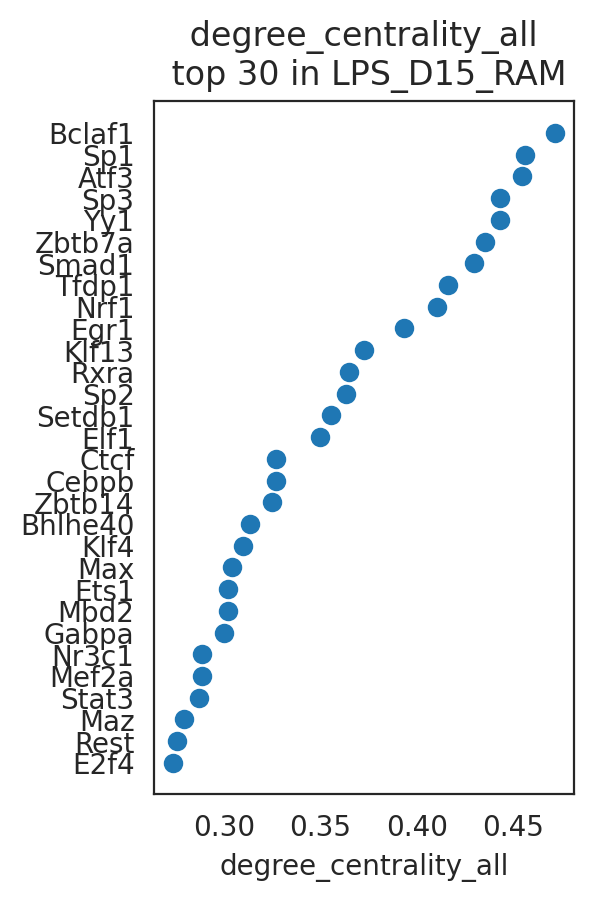

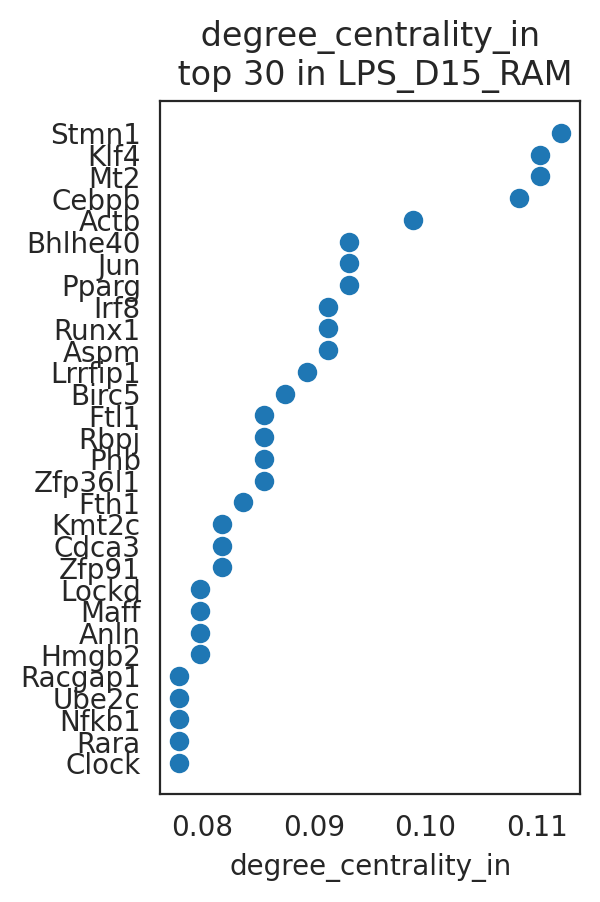

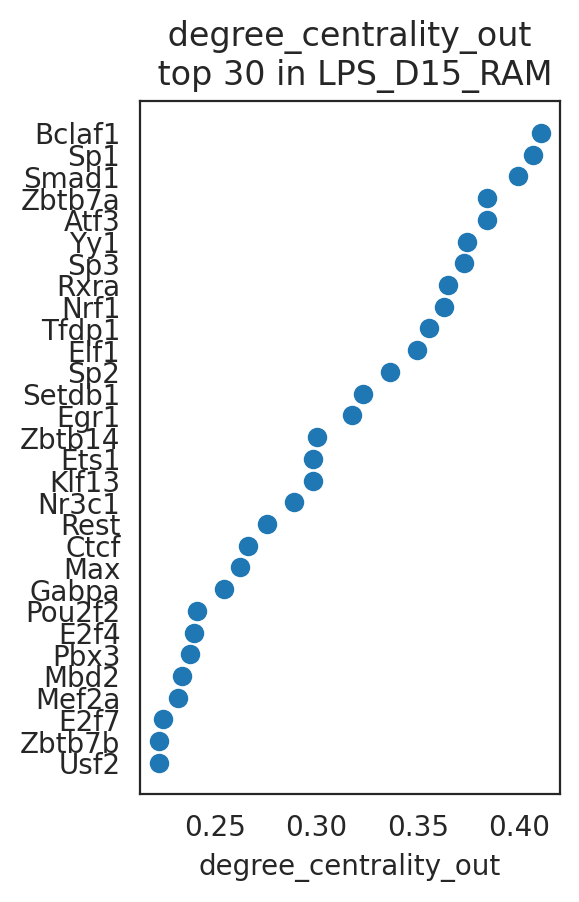

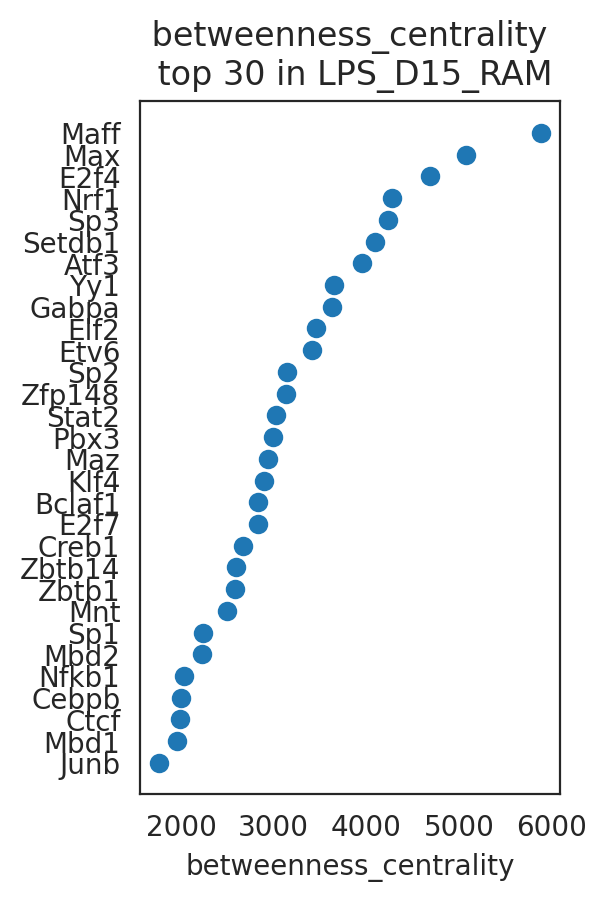

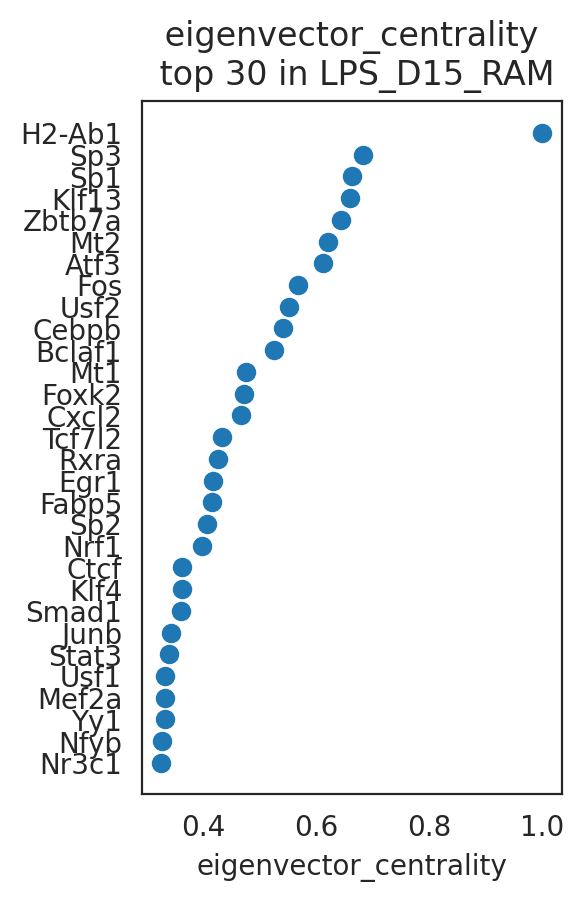

In [22]:
chromlinks.plot_scores_as_rank(cluster='LPS_D15_RAM', n_gene=30, save='20251111_figs')

In [23]:
#links.to_hdf5(file_path='20241021_AM_vanilla.celloracle.links')
chromlinks.to_hdf5(file_path='20251111_MoMRAM_GSE280003_chrombpnet.celloracle.links')

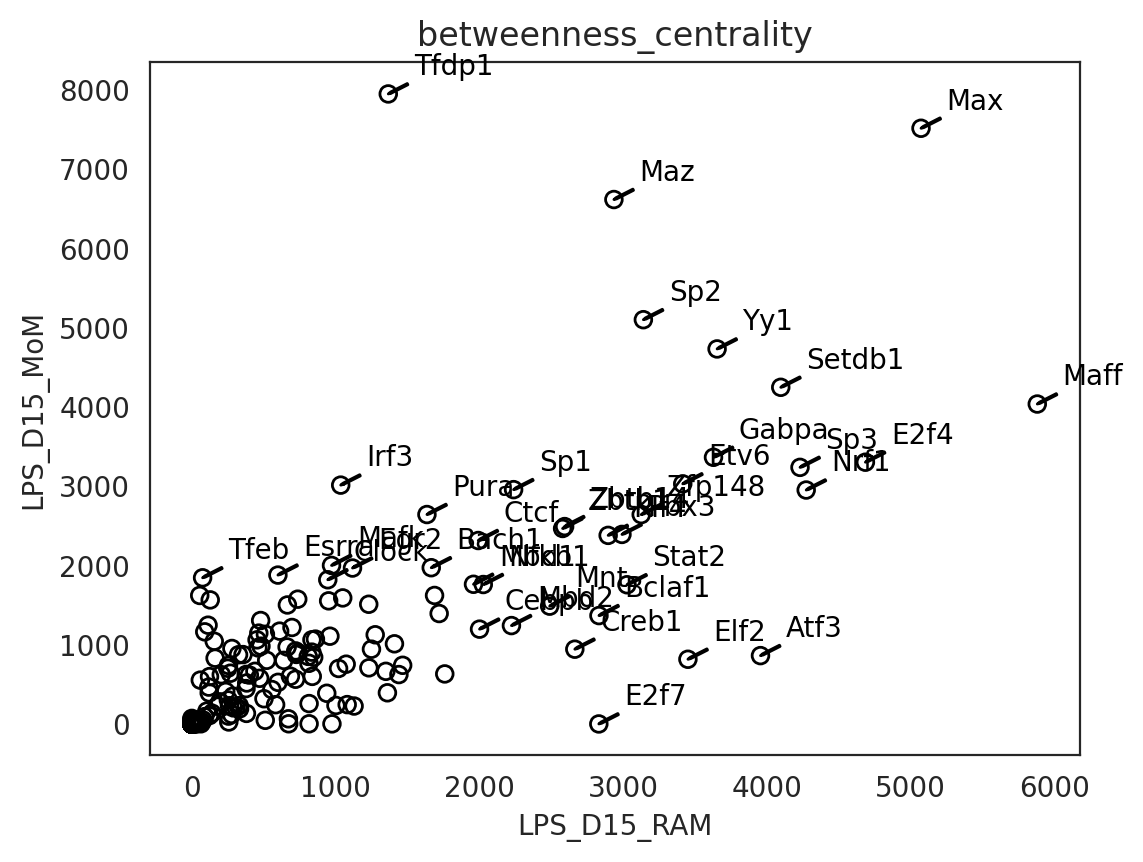

In [56]:
chromlinks.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1='LPS_D15_RAM', cluster2='LPS_D15_MoM',
                               percentile=95, save='20251111_figs')

In [39]:
RAM_d00_filt = chromlinks.links_dict['Homeostasis_D00_RAM'].query('p < 0.05')
RAM_d03_filt = chromlinks.links_dict['LPS_D03_RAM'].query('p < 0.05')
RAM_d06_filt = chromlinks.links_dict['LPS_D06_RAM'].query('p < 0.05')
RAM_d15_filt = chromlinks.links_dict['LPS_D15_RAM'].query('p < 0.05')
MoM_d00_filt = chromlinks.links_dict['Homeostasis_D00_MoM'].query('p < 0.05')
MoM_d03_filt = chromlinks.links_dict['LPS_D03_MoM'].query('p < 0.05')
MoM_d06_filt = chromlinks.links_dict['LPS_D06_MoM'].query('p < 0.05')
MoM_d15_filt = chromlinks.links_dict['LPS_D15_MoM'].query('p < 0.05')

In [42]:
RAM_d00_filt.to_csv('20251111_links/20251111_GSE280003_chrombpnetCellOracle_RAM_D00_links.csv')
RAM_d03_filt.to_csv('20251111_links/20251111_GSE280003_chrombpnetCellOracle_RAM_D03_links.csv')
RAM_d06_filt.to_csv('20251111_links/20251111_GSE280003_chrombpnetCellOracle_RAM_D06_links.csv')
RAM_d15_filt.to_csv('20251111_links/20251111_GSE280003_chrombpnetCellOracle_RAM_D15_links.csv')
MoM_d00_filt.to_csv('20251111_links/20251111_GSE280003_chrombpnetCellOracle_MoM_D00_links.csv')
MoM_d03_filt.to_csv('20251111_links/20251111_GSE280003_chrombpnetCellOracle_MoM_D03_links.csv')
MoM_d06_filt.to_csv('20251111_links/20251111_GSE280003_chrombpnetCellOracle_MoM_D06_links.csv')
MoM_d15_filt.to_csv('20251111_links/20251111_GSE280003_chrombpnetCellOracle_MoM_D15_links.csv')

In [43]:
network_data = chromlinks.merged_score
network_data

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
Rfx5,69,0.128253,9,0.016729,60,0.111524,1541.0,0.521386,Homeostasis_D00_MoM
H2-Ab1,14,0.026022,14,0.026022,0,0.000000,0.0,1.000000,Homeostasis_D00_MoM
Sp3,239,0.444238,33,0.061338,206,0.382900,7282.0,0.570314,Homeostasis_D00_MoM
Nfyc,43,0.079926,14,0.026022,29,0.053903,1599.0,0.374708,Homeostasis_D00_MoM
Sp1,194,0.360595,25,0.046468,169,0.314126,2773.0,0.490477,Homeostasis_D00_MoM
...,...,...,...,...,...,...,...,...,...
Lmo7,1,0.001901,1,0.001901,0,0.000000,0.0,0.000589,LPS_D15_RAM
Adnp,1,0.001901,1,0.001901,0,0.000000,0.0,0.001098,LPS_D15_RAM
Blzf1,4,0.007605,4,0.007605,0,0.000000,0.0,0.002020,LPS_D15_RAM
Egr4,2,0.003802,0,0.000000,2,0.003802,0.0,0.002490,LPS_D15_RAM


In [46]:
network_data.to_csv('20251111_links/20251111_MoMRAM_GSE280003_chrombpnetCellOracle_networkData.csv')

In [3]:
#10Dec25
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
netfile = '20251111_links/20251111_MoMRAM_GSE280003_chrombpnetCellOracle_networkData.csv'
network_data = pd.read_csv(netfile, index_col=0)
network_data['cellType'] = network_data['cluster'].apply(lambda x: x[-3:])
network_data['time'] = network_data['cluster'].apply(lambda x: x[-7:-4])
model = ols('eigenvector_centrality ~ C(cellType) + C(time) + C(cellType):C(time)', data=network_data).fit()
anova_res = sm.stats.anova_lm(model, typ=2)
mc = MultiComparison(network_data['eigenvector_centrality'], network_data['cluster'])
result = mc.tukeyhsd()
result

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster,cellType,time
Rfx5,69,0.128253,9,0.016729,60,0.111524,1541.0,0.521386,Homeostasis_D00_MoM,MoM,D00
H2-Ab1,14,0.026022,14,0.026022,0,0.000000,0.0,1.000000,Homeostasis_D00_MoM,MoM,D00
Sp3,239,0.444238,33,0.061338,206,0.382900,7282.0,0.570314,Homeostasis_D00_MoM,MoM,D00
Nfyc,43,0.079926,14,0.026022,29,0.053903,1599.0,0.374708,Homeostasis_D00_MoM,MoM,D00
Sp1,194,0.360595,25,0.046468,169,0.314126,2773.0,0.490477,Homeostasis_D00_MoM,MoM,D00
...,...,...,...,...,...,...,...,...,...,...,...
Lmo7,1,0.001901,1,0.001901,0,0.000000,0.0,0.000589,LPS_D15_RAM,RAM,D15
Adnp,1,0.001901,1,0.001901,0,0.000000,0.0,0.001098,LPS_D15_RAM,RAM,D15
Blzf1,4,0.007605,4,0.007605,0,0.000000,0.0,0.002020,LPS_D15_RAM,RAM,D15
Egr4,2,0.003802,0,0.000000,2,0.003802,0.0,0.002490,LPS_D15_RAM,RAM,D15


In [16]:
tukey_df = pd.DataFrame(
    result._results_table.data[1:],     # rows
    columns=result._results_table.data[0]  # column names
)
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Homeostasis_D00_MoM,Homeostasis_D00_RAM,0.0711,0.0000,0.0458,0.0963,True
1,Homeostasis_D00_MoM,LPS_D03_MoM,0.0072,0.9884,-0.0179,0.0323,False
2,Homeostasis_D00_MoM,LPS_D03_RAM,0.0973,0.0000,0.0720,0.1226,True
3,Homeostasis_D00_MoM,LPS_D06_MoM,0.0574,0.0000,0.0323,0.0824,True
4,Homeostasis_D00_MoM,LPS_D06_RAM,0.0491,0.0000,0.0239,0.0743,True
5,Homeostasis_D00_MoM,LPS_D15_MoM,0.0048,0.9991,-0.0203,0.0299,False
6,Homeostasis_D00_MoM,LPS_D15_RAM,0.0389,0.0001,0.0137,0.0641,True
7,Homeostasis_D00_RAM,LPS_D03_MoM,-0.0638,0.0000,-0.0891,-0.0386,True
8,Homeostasis_D00_RAM,LPS_D03_RAM,0.0262,0.0376,0.0008,0.0517,True
9,Homeostasis_D00_RAM,LPS_D06_MoM,-0.0137,0.7191,-0.0389,0.0115,False
